In [1]:
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np

from imagedata import ImageData
from mupify import mupify

import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=14)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
plt.rc("mathtext", fontset='cm')


In [2]:
def test_error(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            d_out = output.shape[1]
            test_loss += F.mse_loss(output, target, reduction='sum').item() / d_out
            pred = output.argmax(dim=1)
            correct += (pred==target.argmax(dim=1)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

# MNIST tests

In [3]:
class SimpleMLP(nn.Module):
    
    def __init__(self, d_in, d_out, width):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, d_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
WIDTH = 512
param = 'stp'           # choose between 'stp', 'mup', 'or 'ntp'
gamma = np.sqrt(WIDTH)  # gamma=None also assigns gamma=sqrt(width) by default

model = SimpleMLP(d_in=784, d_out=10, width=WIDTH).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, readin='fc1', readout='fc3',
       width=WIDTH, param=param, gamma=gamma)

print("== Output scale ==")
print(f"{model(torch.ones(784).cuda()).std().item():.4f}")
print()

print("== Init weight scale ==")
for k, v in model.named_modules():
    if not hasattr(v, 'weight'):
        continue
    print(f"{k:<20} {v.weight.std().item():.4f}")
print()

print("== Layerwise learning rates ==")
for name, param in model.named_parameters():
    for pg in optimizer.param_groups:
        if id(param) in [id(p) for p in pg['params']]:
            print(f"{name:<20} {pg['lr']:.4f}")

== Output scale ==
0.0540

== Init weight scale ==
fc1                  0.0505
fc2                  0.0626
fc3                  0.0028

== Layerwise learning rates ==
fc1.weight           0.6531
fc1.bias             0.6531
fc2.weight           1.0000
fc2.bias             1.0000
fc3.weight           0.0020
fc3.bias             0.0020


In [5]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(5000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

In [6]:
ntrials = 5
nepochs = 15
test_errors = np.empty((3, 2, ntrials, nepochs))

WIDTH = 512
for i, param in enumerate(['stp', 'mup', 'ntp']):
    for j, gamma in enumerate([1, np.sqrt(WIDTH)]):
        for trial in range(ntrials):
            model = SimpleMLP(d_in=784, d_out=10, width=WIDTH).to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
            mupify(model, optimizer, readin=model.fc1, readout=model.fc3,
                   width=WIDTH, param=param, gamma=gamma)
            for epoch in range(nepochs):
                print('.', end='')
                test_loss, accuracy = test_error(model, test_loader)
                test_errors[i, j, trial, epoch] = test_loss
                for batch_idx, (data, target) in enumerate(train_loader):
                    optimizer.zero_grad()
                    output = model(data)
                    loss = F.mse_loss(output, target)
                    loss.backward()
                    optimizer.step()
        print()


...........................................................................
...........................................................................
...........................................................................
...........................................................................
...........................................................................
...........................................................................


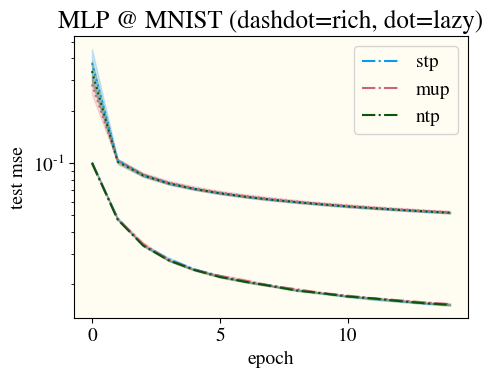

In [8]:
plt.figure(figsize=(5, 4))

colors = ['xkcd:azure', 'xkcd:rose', 'xkcd:forest']
labels = ['stp', 'mup', 'ntp']
ls = [':', '-.']
for i, param in enumerate(labels):
    for j, gamma in enumerate([1, np.sqrt(WIDTH)]):
        label = labels[i] if j==1 else ''
        color = colors[i]
        acc = test_errors[i, j]
        mean, std = acc.mean(axis=0), acc.std(axis=0)
        epochs = np.arange(len(mean))
        plt.plot(epochs, mean, color=color, label=label, ls=ls[j])
        plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=color)

plt.title('MLP @ MNIST (dashdot=rich, dot=lazy)')
plt.legend()
plt.yscale('log')
plt.ylabel('test mse')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

# CIFAR10 tests

In [403]:
class Myrtle5(nn.Module):
    
    def __init__(self, chan_in=3, d_out=10, width=512):
        super().__init__()
        ksz = 3
        self.conv1 = nn.Conv2d(chan_in, width, ksz, padding='same')
        self.conv2 = nn.Conv2d(width, width, ksz, padding='same')
        self.conv3 = nn.Conv2d(width, width, ksz, padding='same')
        self.conv4 = nn.Conv2d(width, width, ksz, padding='same')
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.readout = nn.Linear(width, d_out)

    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = self.pool(F.relu(self.conv2(h1)))
        h3 = self.pool(F.relu(self.conv3(h2)))
        h4 = self.gap(F.relu(self.conv4(h3)))
        return self.readout(h4.squeeze())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [405]:
WIDTH = 512
param = 'mup'
gamma = np.sqrt(WIDTH)

model = Myrtle5(chan_in=3, d_out=10, width=WIDTH).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, readin='conv1', readout='readout',
       width=WIDTH, param=param, gamma=gamma)

print("== Output scale ==")
print(f"{model(torch.ones((3, 32, 32)).cuda()).std().item():.4f}")
print()

print("== Init weight scale ==")
for k, v in model.named_modules():
    if not hasattr(v, 'weight'):
        continue
    print(f"{k:<20} {v.weight.std().item():.4f}")
print()

print("== Layerwise learning rates ==")
for name, param in model.named_parameters():
    for pg in optimizer.param_groups:
        if id(param) in [id(p) for p in pg['params']]:
            print(f"{name:<20} {pg['lr']:.4f}")

== Output scale ==
0.0485

== Init weight scale ==
conv1                0.0631
conv2                0.0625
conv3                0.0625
conv4                0.0625
readout              0.0632

== Layerwise learning rates ==
conv1.weight         1.0000
conv1.bias           1.0000
conv2.weight         1.0000
conv2.bias           1.0000
conv3.weight         1.0000
conv3.bias           1.0000
conv4.weight         1.0000
conv4.bias           1.0000
readout.weight       1.0000
readout.bias         1.0000


In [404]:
imdata = ImageData("cifar10", 'data')
X_train, y_train = imdata.get_dataset(10000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [407]:
ntrials = 5
nepochs = 15
test_errors = np.empty((3, 2, ntrials, nepochs))

WIDTH = 128
for i, param in enumerate(['stp', 'mup', 'ntp']):
    for j, gamma in enumerate([1, np.sqrt(WIDTH)]):
        for trial in range(ntrials):
            model = Myrtle5(chan_in=3, d_out=10, width=WIDTH).to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
            mupify(model, optimizer, readin='conv1', readout='readout',
                   width=WIDTH, param=param, gamma=gamma)
            for epoch in range(nepochs):
                print('.', end='')
                test_loss, accuracy = test_error(model, test_loader)
                test_errors[i, j, trial, epoch] = test_loss
                for batch_idx, (data, target) in enumerate(train_loader):
                    optimizer.zero_grad()
                    output = model(data)
                    loss = F.mse_loss(output, target)
                    loss.backward()
                    optimizer.step()
        print()

...........................................................................
...........................................................................
...........................................................................
...........................................................................
...........................................................................
...........................................................................


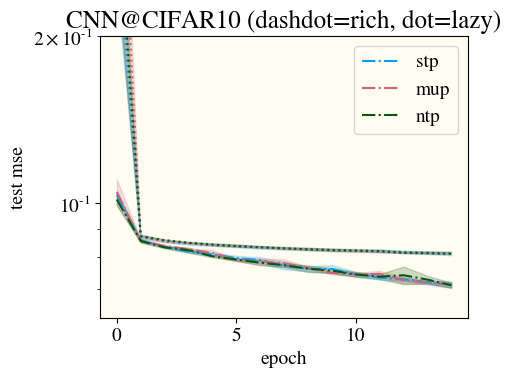

In [410]:
plt.figure(figsize=(5, 4))

colors = ['xkcd:azure', 'xkcd:rose', 'xkcd:forest']
labels = ['stp', 'mup', 'ntp']
ls = [':', '-.']
for i, param in enumerate(labels):
    for j, gamma in enumerate([1, np.sqrt(WIDTH)]):
        label = labels[i] if j==1 else ''
        color = colors[i]
        acc = test_errors[i, j]
        mean, std = acc.mean(axis=0), acc.std(axis=0)
        epochs = np.arange(len(mean))
        plt.plot(epochs, mean, color=color, label=label, ls=ls[j])
        plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=color)

plt.title('CNN@CIFAR10 (dashdot=rich, dot=lazy)')
plt.legend()
plt.yscale('log')
plt.ylabel('test mse')
plt.ylim(top=0.2)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()